In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union

import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from minisom import MiniSom

from IPython.display import display, HTML

from tsai.all import *

## Pré-processamento dos dados

### Cálculo do GPP

In [2]:
@contextmanager
def cwd(path: str) -> None:
    
    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """
    
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def constructor_2(path):
    df = pd.read_csv(path, parse_dates=['date'])
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

#==================================== Funções do Software do MOD17

def linear_constraint(
        xmin, xmax, form: str = None):
    assert form is None or form in ('reversed', 'binary'),\
        'Argument "form" must be None or one of: "reversed", "binary"'
    assert form == 'binary' or np.any(xmax >= xmin),\
        'xmax must be greater than/ equal to xmin'
    if form == 'reversed':
        return lambda x: np.where(x >= xmax, 0,
            np.where(x < xmin, 1, 1 - np.divide(
                np.subtract(x, xmin), xmax - xmin)))
    if form == 'binary':
        return lambda x: np.where(x == 1, xmax, xmin)
    return lambda x: np.where(x >= xmax, 1,
        np.where(x < xmin, 0,
            np.divide(np.subtract(x, xmin), xmax - xmin)))

def _gpp(params, fpar, tmin, vpd, par):
    'Daily GPP as static method, avoids overhead of class instantiation'
    # "params" argument should be a Sequence of atomic parameter values
    #   in the order prescribed by "required_parameters"
    tmin_scalar = linear_constraint(params[1], params[2])(tmin)
    vpd_scalar = linear_constraint(
        params[3], params[4], form = 'reversed')(vpd)
    lue = params[0] * tmin_scalar * vpd_scalar
    return 1e3 * lue * fpar * par

def _par(sw_rad: Number, period_hrs: Number = 1) -> Number:
    '''
    Calculates daily total photosynthetically active radiation (PAR) from
    (hourly) incoming short-wave radiation (SW_rad). PAR is assumed to
    be 45% of SW_rad.

    Parameters
    ----------
    swrad : int or float or numpy.ndarray
        Incoming short-wave radiation (W m-2)
    period_hrs : int
        Period over which radiation is measured, in hours (Default: 1)

    Returns
    -------
    int or float or numpy.ndarray
    '''
    # Convert SW_rad from [W m-2] to [MJ m-2], then take 45%;
    #   3600 secs hr-1 times (1 MJ / 1e6 Joules) == 0.0036
    return 0.45 * (0.0036 * (24 / period_hrs) * sw_rad)

def _vpd(qv10m: Number, pressure: Number, tmean: Number) -> Number:
    '''
    Computes vapor pressure deficit (VPD) from surface meteorology.

    Parameters
    ----------
    qv10m : int or float or numpy.ndarray
        Water vapor mixing ratio at 10-meter height (Pa)
    pressure : int or float or numpy.ndarray
        Atmospheric pressure (Pa)
    tmean : int or float or numpy.ndarray
        Mean daytime temperature (degrees C)

    Returns
    -------
    int or float or numpy.ndarray
    '''
    # Actual vapor pressure (Gates 1980, Biophysical Ecology, p.311)
    avp = (qv10m * pressure) / (0.622 + (0.379 * qv10m))
    # Saturation vapor pressure (similar to FAO formula)
    svp = 610.7 * np.exp((17.38 * tmean) / (239 + tmean))
    return svp - avp
#==================================== Funções do Software do MOD17



def create_drivers():
    """Função para calcular o valor dos parâmetros necessários para calcular o GPP de cada área"""
    date = 0
    drivers_dict = {}
    with cwd('./merra'):
        for folder in os.listdir():
            with cwd(folder):
                csvs = sorted(os.listdir())

                tday = constructor_2(f'{csvs[4]}') - 273.15 #( K° -> C°)
                tmin = tday['T10M'].resample('D').min()['2000-02-26':].values  # Reamostrando para Temperatura mínima diária
                tmean = tday['T10M'].resample('D').mean().values  # Temperatura média diária
                tmean_vpd = tday['T10M'].between_time('9:00', '21:00').resample('D').mean()['2000-02-26':].values
            
                # Leitura e pré-processamento dos dados de razão de mistura de vapor de água
                qv10m = constructor_2(f'{csvs[2]}')['2000-02-26':] # unidade: "Mass fraction" (kg/kg)
                qv10m = pd.to_numeric(qv10m['QV10M']).between_time('9:00', '21:00').resample('D').mean().values

                # Leitura e pré-processamento dos dados de pressão atmosférica
                ps = constructor_2(f'{csvs[1]}') # unidade: Pa  # Removendo vírgulas dos valores
                ps['PS'] = pd.to_numeric(ps['PS'])
                ps = ps.between_time('9:00', '21:00').resample('D').mean()['2000-02-26':]
                ps = pd.to_numeric(ps['PS']).values

                # Leitura e pré-processamento dos dados de radiação solar incidente
                SWGNT = constructor_2(f'{csvs[3]}')['SWGNT'].resample('D').mean()['2000-02-26':].values # unidade: W/m^2

                # Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
                fpar = pd.read_csv(f'{csvs[0]}', header=None,na_values='F') # unidade: (%)
                fpar.index = fpar[2].apply(modis_date)  # Convertendo a data no formato MODIS

                # Arrumando o dataframe
                # ================================
                fpar = fpar.drop([0,1,2,3,4], axis=1)
                fpar.columns = range(len(fpar.columns))
                fpar = fpar[144]

                # ================================

                # Tratamento de dados faltando usando interpolação linear (8 dias -> diário)
                
                fpar = fpar['2000-02-26':'2022-01-01'].resample('D').interpolate('linear')[:-1]
                fpar = fpar.values if folder != 'amazonia peruana' else fpar.values/100
                
                
                drivers = [
                    fpar[:][...,None],
                    tmin[:][...,None],
                    _vpd(qv10m, ps, tmean_vpd)[...,None],
                    _par(SWGNT)[:][...,None]
                ]
                drivers[2] = np.where(drivers[2] < 0, 0, drivers[2]) # Set negative VPD to zero
                
                
                date = tday['T10M'].resample('D').min()['2000-02-26':].index
                drivers_dict[folder] = drivers
    return date, drivers_dict
        
        
parametros = [0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397]

drivers = create_drivers()


index_date = drivers[0] # Data associada aos dados

drivers_peru, drivers_santarem, drivers_caxiuana = drivers[1].values() # Dados de cada região



gpp_peru = np.nanmean(_gpp(parametros,*drivers_peru), axis = -1) # gpp calculado

gpp_santarem = np.nanmean(_gpp(parametros,*drivers_santarem), axis = -1) 

gpp_cax = np.nanmean(_gpp(parametros,*drivers_caxiuana), axis = -1)


gpp_peru = pd.DataFrame(gpp_peru,index=index_date)
gpp_santarem = pd.DataFrame(gpp_santarem,index=index_date)
gpp_cax = pd.DataFrame(gpp_cax,index=index_date)

gpp_peru = ExponentialSmoothing(gpp_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
gpp_santarem = ExponentialSmoothing(gpp_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
gpp_cax = ExponentialSmoothing(gpp_cax, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

gpp_peru = pd.DataFrame(gpp_peru,index=index_date) # Convertendo de volta pra um dataframe
gpp_santarem = pd.DataFrame(gpp_santarem,index=index_date)
gpp_cax = pd.DataFrame(gpp_cax,index=index_date)

### Criação da janela temporal

In [4]:
# O modis gera 1 valor de gpp a cada 8 dias
# Adaptando essa estrutura... Até pro nosso modelo poder ser comparado com as estimativas do modis
# Decidi por colocar uma janela de 8 dias para previsão
peru_x,peru_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru) #  stride = n datapoints the window is moved ahead along the sequence. 
                                                                                    # Default: 1. If None, stride=window_length (no overlap)
santarem_x,santarem_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem)
cax_x,cax_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax)

In [5]:
def df_xy(x,y):
    x_df = pd.DataFrame(x[:,0]).reset_index().drop('index',axis=1) 
    x_df.columns = [f'janela {i}' for i in range(len(x_df.columns))]

    y_df = pd.DataFrame(y).reset_index().drop('index',axis=1) 
    y_df.columns = [f'previsao {i}' for i in range(len(y_df.columns))]

    return pd.concat([x_df,y_df],axis=1)

peru_df = df_xy(peru_x,peru_y)
santarem_df = df_xy(santarem_x,santarem_y)
cax_df = df_xy(cax_x,cax_y)
peru_df['localidade'] = 'peru'
santarem_df['localidade'] = 'santarem'
cax_df['localidade'] = 'caxiuana'

In [6]:
#Código usável para 1 horizonte

# peru_x,peru_y = SlidingWindow(15,horizon=1,seq_first=True,stride = None)(gpp_peru) #  stride = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
# santarem_x,santarem_y = SlidingWindow(15,horizon=1,seq_first=True,stride = None)(gpp_santarem)
# cax_x,cax_y = SlidingWindow(15,horizon=1,seq_first=True,stride = None)(gpp_cax)

# Dataframe de cada localidade
# peru_df = pd.DataFrame(peru_x[:,0],peru_y[:,0]).reset_index()  
# peru_df.columns = range(len(peru_df.columns))

# santarem_df = pd.DataFrame(santarem_x[:,0],santarem_y[:,0]).reset_index()
# santarem_df.columns = range(len(santarem_df.columns))

# cax_df = pd.DataFrame(cax_x[:,0],cax_y[:,0]).reset_index()
# cax_df.columns = range(len(cax_df.columns))

# peru_df['localidade'] = 'peru'
# santarem_df['localidade'] = 'santarem'
# cax_df['localidade'] = 'caxiuana'

In [14]:
gpp_geral = pd.concat([peru_df,santarem_df,cax_df]).reset_index().drop('index',axis=1)

### Clusterização com MiniSom

In [15]:
#!pip install minisom
norm = preprocessing.Normalizer()

datos = norm.fit_transform(gpp_geral.drop('localidade',axis=1).values)

quant_error = {'quant_error':[],'sigma':[],'learning_rate':[]}

for i in range(1,65):
    som_shape = (i, i) # ainda arbitrário
    lr = np.random.random()
    sigma = np.random.random()
    som = MiniSom(som_shape[0], som_shape[1], datos.shape[1], sigma=sigma, learning_rate=lr,
                  neighborhood_function='gaussian',activation_distance='manhattan')

    som.train_batch(datos, 1000, verbose=False)
    quant_error['quant_error'].append(som.quantization_error(datos))
    quant_error['sigma'].append(sigma)
    quant_error['learning_rate'].append(lr)

In [16]:
i = np.argmin(np.array(quant_error['quant_error']))

np.array(quant_error['sigma'])[i], np.array(quant_error['learning_rate'])[i]

(0.9742875513971496, 0.2887845764727245)

In [17]:
np.array(quant_error['quant_error'])[i]

0.08820689315343397

In [18]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in datos]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
gpp_geral['cluster'] = np.array(cluster_index)

In [19]:
gpp_geral[['localidade','cluster']].value_counts()

localidade  cluster
santarem    1269       386
caxiuana    1269       169
santarem    1333       146
            1332       112
caxiuana    1332       104
                      ... 
santarem    1078         1
peru        1077         1
santarem    2212         1
            2273         1
            1208         1
Name: count, Length: 104, dtype: int64

In [20]:
# Contar o número de ocorrências de cada cluster por localidade
cluster_counts = gpp_geral.groupby(['localidade', 'cluster']).size()

# Filtrar os clusters para apenas os que possuem mais de 6 ocorrências
valid_clusters = cluster_counts[cluster_counts > 6].index

# Manter apenas as linhas cujo cluster e localidade estão nos clusters e localidades válidos
gpp_geral = gpp_geral[gpp_geral.set_index(['localidade', 'cluster']).index.isin(valid_clusters)].copy()

In [21]:
gpp_geral[['localidade','cluster']].value_counts()

localidade  cluster
santarem    1269       386
caxiuana    1269       169
santarem    1333       146
            1332       112
caxiuana    1332       104
                      ... 
santarem    1268         9
caxiuana    1144         9
peru        1398         9
            2273         7
caxiuana    1398         7
Name: count, Length: 80, dtype: int64

### Divisão de treino e Teste

In [22]:
df = gpp_geral.reset_index().drop('index',axis=1)

janela = [f'janela {i}' for i in range(0,15)]
previsao = [f'previsao {i}' for i in range(0,7)]


X = df.drop(columns=['localidade', 'cluster']).drop(columns=previsao)  # Aqui ficam 15 colunas representado instantes da janela temporal
y = df[previsao] # Aqui fica o 16° valor da sequência
z = df[['localidade','cluster']]

# Dividir os dados em treino e teste estratificados por 'localidade' e 'cluster'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=z)

train_data = pd.concat([X_train, y_train], axis=1).sample(frac=1).reset_index(drop=True)
X_train = train_data.drop(columns=previsao)
y_train = train_data[previsao]

# Dividindo os dados em validação

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, stratify=z.loc[X_test.index])

val_data = pd.concat([X_val, y_val], axis=1).sample(frac=1).reset_index(drop=True)
X_val = val_data.drop(columns=previsao)
y_val = val_data[previsao]

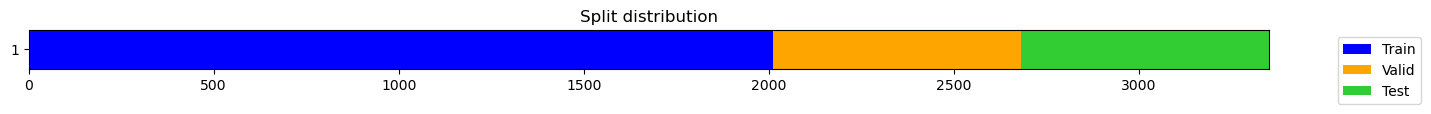

In [23]:
#plits = TSSplitter(valid_size=0.2, show_plot=True)(y_train)
X,y,splits = combine_split_data(xs=[X_train,X_val,X_test],ys=[y_train,y_val,y_test]) # estrutura pro modelo entender a divisão do dataset em treino teste e validação
plot_splits(splits)

bs = 512 # batch size

tfms = [None, TSForecasting()]
#dsets = TSDatasets(X, y.values, tfms=tfms, splits=splits)
#dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2], batch_tfms=TSStandardize()) # batch_tfms = batch transformations

In [25]:
X.shape

(3350, 1, 7)

### Testes com os modelos

In [26]:
from torch_optimizer import *
otimizadores = [PID,Lamb,NovoGrad,QHAdam,QHM,RAdam,SGDP,SGDW,Shampoo,SWATS,Yogi,AdaBound,AdaMod,AdamP,]
#SWATS = wrap_optimizer(optim.AdaBound)

,arch,hyperparams,total params,train loss,valid loss,mae_valid,r2_valid,mae_test,r2_test,time,otimizador
0,TSTPlus,{},398721,49.545300,49.014629,6.874904,-10.989478,6.851247,-7.285452,279,Lamb
1,RNNPlus,{},10401,4.738979,4.443272,1.590168,-2.225853,1.574179,0.272279,162,Lamb
2,TransformerGRUPlus,{},792577,3.056609,2.962130,1.303517,0.035460,1.322137,0.493763,1114,PID
3,TransformerLSTMPlus,{},858625,2.993175,2.917909,1.288774,0.064373,1.293080,0.511938,926,PID
4,RNNPlus,{},10401,2.914504,2.900127,1.288146,0.037594,1.272736,0.523381,163,PID
5,TSSequencerPlus,{},208631,2.711149,2.679911,1.230845,0.174546,1.212769,0.561744,779,PID
6,XceptionTimePlus,{},234865,2.330408,2.288095,1.133120,0.220772,1.127832,0.617122,440,PID
7,ResNetPlus,{},478337,0.891387,2.363094,1.089249,0.503849,1.062682,0.618748,260,Lamb
8,InceptionTimePlus,{},454977,0.645492,2.310225,1.087072,0.531433,1.086051,0.610884,371,PID
9,ResNetPlus,{},478337,0.942344,2.087662,1.049293,0.509156,1.024303,0.660599,262,PID


TSForecaster


epoch,train_loss,valid_loss,mae,r2_score,time
0,52.359344,50.922150,6.722475,-24742.452435,00:01
1,52.099392,50.852150,6.717299,-24506.236970,00:01
2,52.418175,50.781086,6.712041,-24259.793159,00:01
3,52.176136,50.707989,6.706627,-24016.242375,00:01
4,52.010246,50.632164,6.701004,-23765.229547,00:01
5,52.156708,50.552704,6.695108,-23491.791774,00:01
6,52.010338,50.468781,6.688872,-23216.508412,00:01
7,51.942566,50.379688,6.682246,-22922.806801,00:01
8,52.082554,50.284672,6.675172,-22607.548832,00:01
9,51.937256,50.182934,6.667586,-22277.049117,00:01


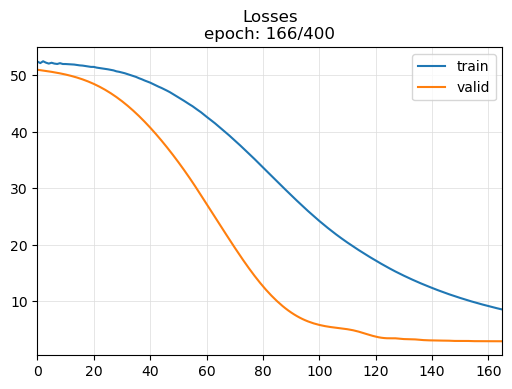

,train_loss,valid_loss,mae,r2_score
165,8.571502,2.967113,1.303909,-0.028852


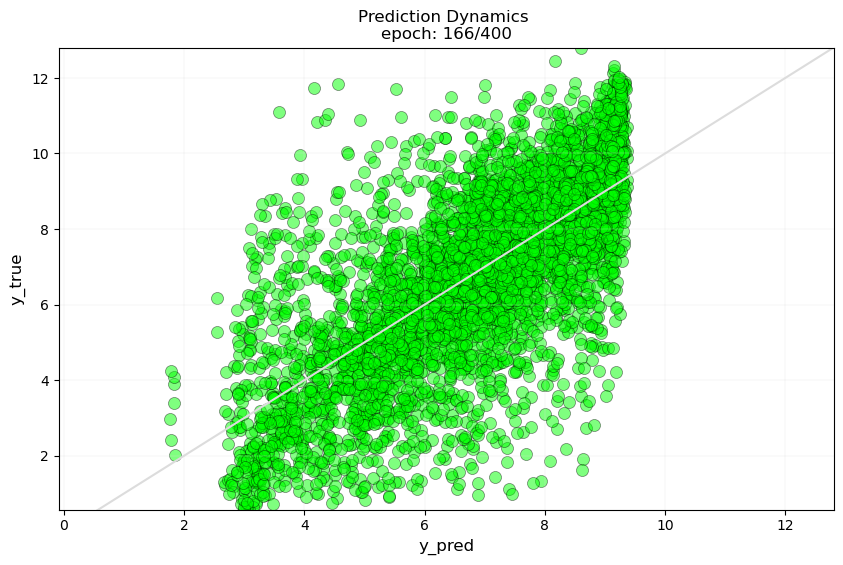

In [ ]:
archs = [
         (ConvTranPlus, {}),
         (TSSequencerPlus, {}),      # Arquiteturas que estou testando (ainda arbitrário). 
         (RNNPlus, {}),                         #Os dicionários do lado do nome de cada arquitetura são específicos dos parâmetros 
         (ResNetPlus, {}),                              # EX: (LSTM, {'n_layers':1, 'bidirectional': False})
         (InceptionTimePlus, {}),
         (TSTPlus, {}),
         (TransformerLSTMPlus, {}),
         (XceptionTimePlus, {}),
         (TransformerGRUPlus, {}),
         (XCMPlus, {}),

        ]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae_valid','r2_valid','mae_test','r2_test','time', 'otimizador'])
i=0
for otimizador in otimizadores:
    for _, (arch, k) in enumerate(archs):
        learn = TSForecaster(X, y.values, splits=splits, path='models', tfms=tfms, batch_tfms=TSStandardize(), bs=1024, arch=f"{arch.__name__}", metrics=[mae,r2_score], cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)],opt_func=wrap_optimizer(otimizador))
        #model = create_model(arch, dls=dls, **k)
        print(learn.__class__.__name__)
        #learn = Learner(dls, model,metrics=[mae,r2_score], cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)]) # dataset , modelo, métricas avaliadas, gráficos de perda e dispersão
        lr = learn.lr_find() # learning rate find
        start = time.time()
        learn.fit_one_cycle(400, lr_max=lr.valley)
        elapsed = time.time() - start
        vals = learn.recorder.values[-1]
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]], y.values[splits[2]])
        mae_test = mean_absolute_error(y_pred=raw_preds,y_true=target)
        r2_test = r2_score(y_pred=raw_preds,y_true=target)
        results.loc[i] = [arch.__name__, k, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3], mae_test, r2_test, int(elapsed), f'{otimizador.__name__}']
        results.sort_values(by=['mae_valid','r2_valid','mae_test','r2_test'], ascending=False, kind='stable', ignore_index=True, inplace=True)
        clear_output()
        display(results)
        i+=1

In [66]:

#plt.figure(figsize=(25,6))
#plt.plot(raw_preds)
#plt.plot(target)
#plt.legend(['Previsto','Verdadeiro'])
print(r2_score(y_pred=raw_preds,y_true=target))

print(mean_squared_error(y_pred=raw_preds,y_true=target,squared=False))
display(np.corrcoef(raw_preds,target))

0.6859977283919853
0.99343365
1.2972811


array([[ 1.        , -0.83788525, -0.40467904, ..., -0.49919761,
        -0.24390451, -0.83263866],
       [-0.83788525,  1.        ,  0.49420819, ...,  0.23210053,
        -0.12773149,  0.70713215],
       [-0.40467904,  0.49420819,  1.        , ...,  0.05385875,
        -0.56747432,  0.60432777],
       ...,
       [-0.49919761,  0.23210053,  0.05385875, ...,  1.        ,
         0.71847911,  0.67523936],
       [-0.24390451, -0.12773149, -0.56747432, ...,  0.71847911,
         1.        ,  0.24501637],
       [-0.83263866,  0.70713215,  0.60432777, ...,  0.67523936,
         0.24501637,  1.        ]])

## Testes Avulsos

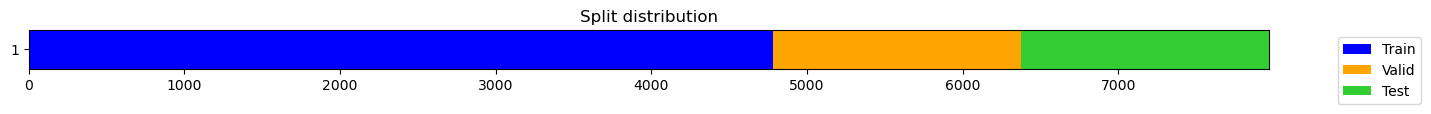

X      - shape: [7965 samples x 1 features x 15 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (7965,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 3 shape: [4779, 1593, 1593]  overlap: False


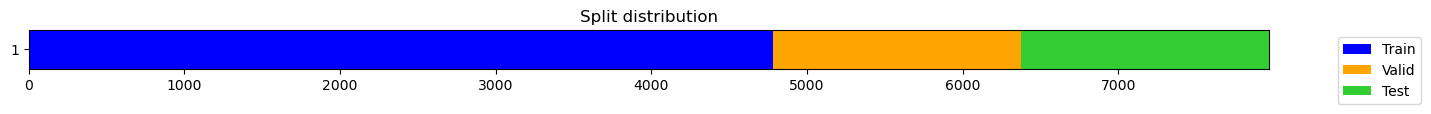

In [44]:
batch_tfms = TSStandardize(by_sample=True)
fcst = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=512, arch="LSTM", metrics=[mae,rmse], cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)])
check_data(X, y, splits)

In [46]:
from sklearn.metrics import r2_score
print(r2_score(y_pred=raw_preds,y_true=target))
print(mean_squared_error(y_pred=raw_preds,y_true=target,squared=False))
print(np.corrcoef(raw_preds[:,0],target))

0.507557354050215
1.7607971
[[1.         0.71982345]
 [0.71982345 1.        ]]


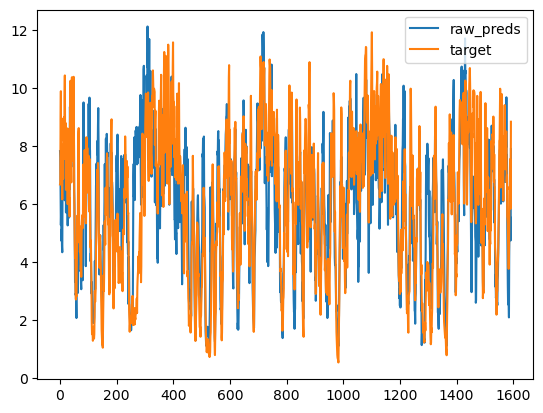

In [19]:
plt.plot(raw_preds)
plt.plot(target)
plt.legend(['raw_preds','target'])